In [28]:
import sys, os , torch
sys.path.append(os.getcwd())        # ensure current folder is on the path
import import_ipynb                 # enables importing .ipynb
from gpt import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim" : 768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

# text generation process

In [29]:
import tiktoken
from gpt import generate_text_simple
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_text = torch.tensor(encoded).unsqueeze(0)
    return encoded_text
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx= text_to_token_ids(start_context, tokenizer),
    max_new_tokens =10,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output text:\n",token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [30]:
inputs =torch.tensor([[16833, 3626, 6100], #["every effort moves"]
                      [40, 1107, 588]]) #["I really like"]
targets = torch.tensor([
    [3626, 6100, 345], #["effort moves you"]
    [1107, 588, 11311] #["really like chocolate"]
])

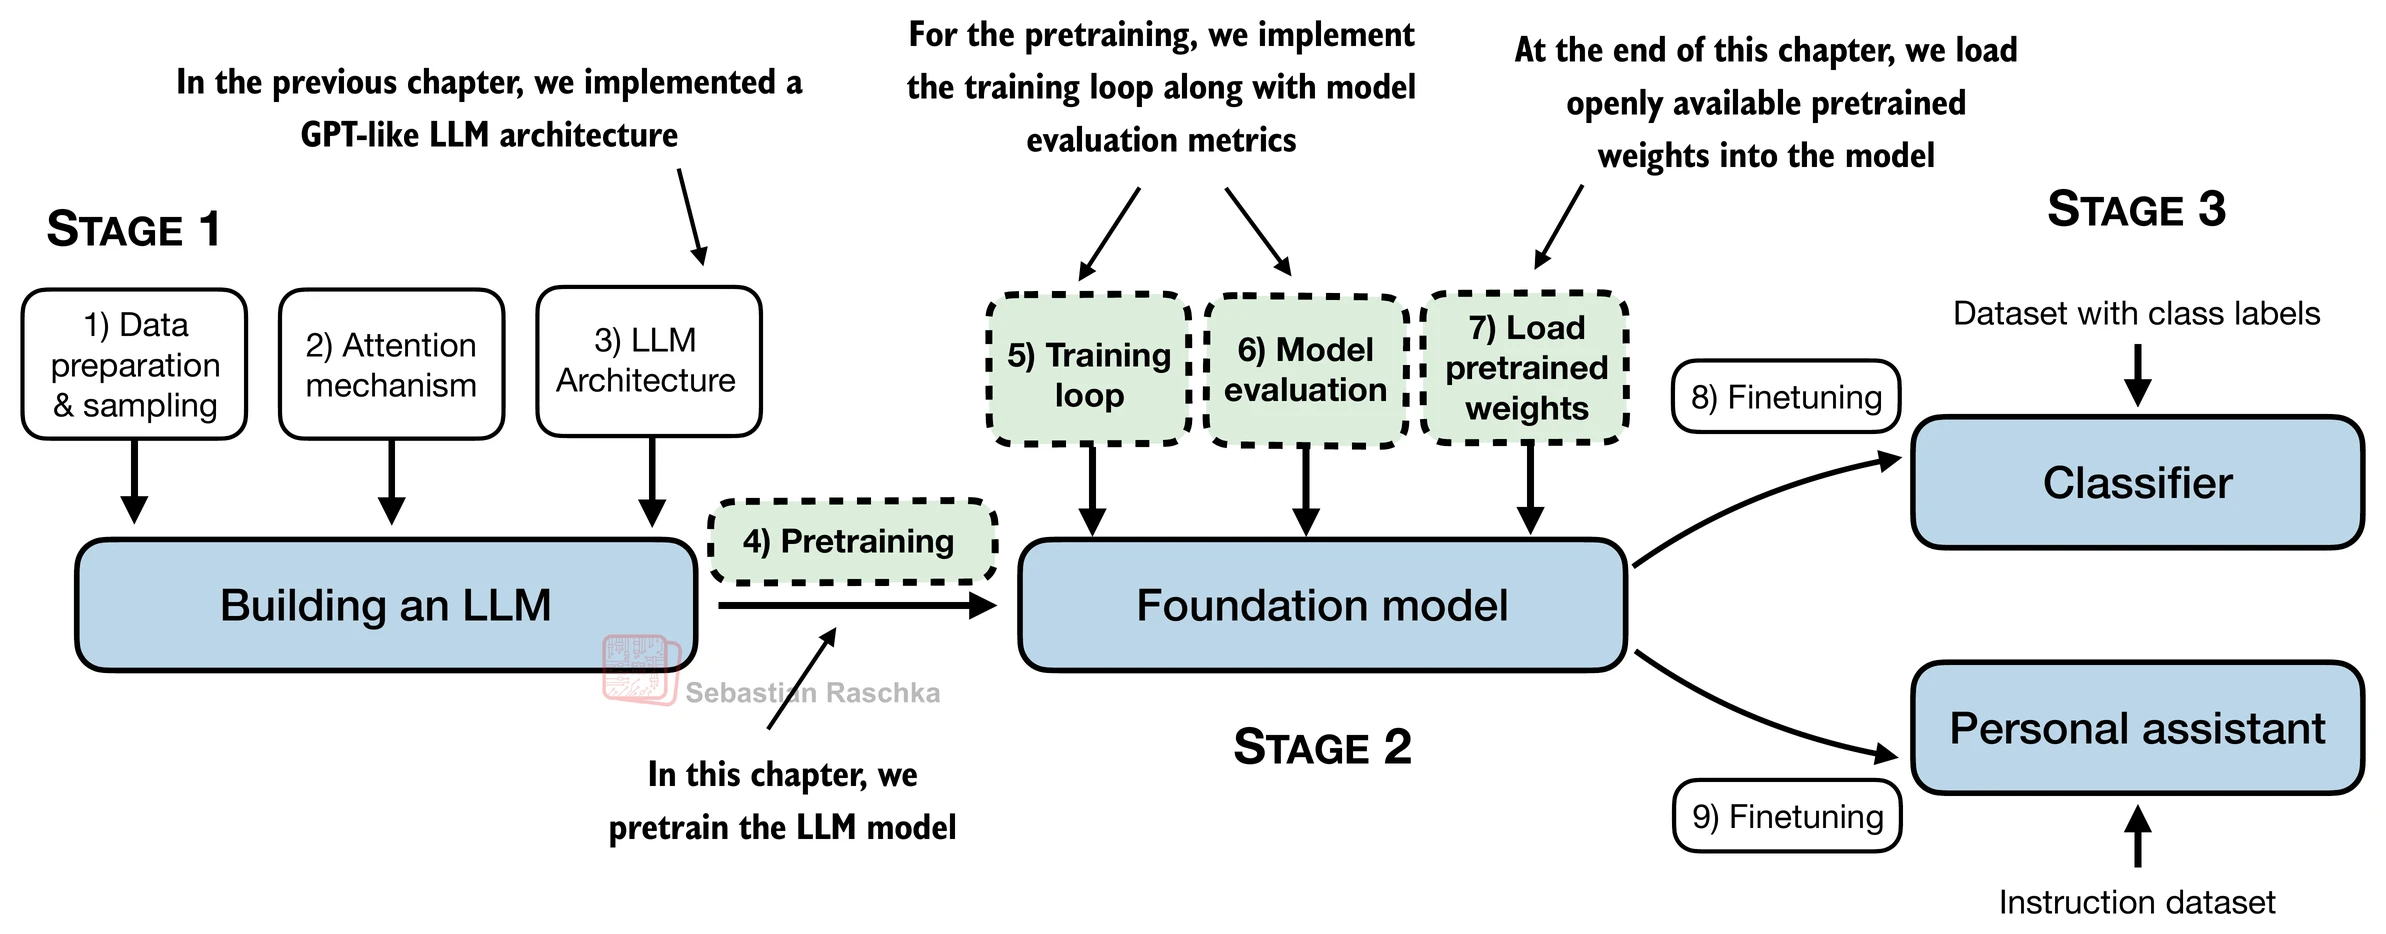

In [31]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [32]:
token_ids = torch.argmax(probas, dim=-1, keepdim = True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


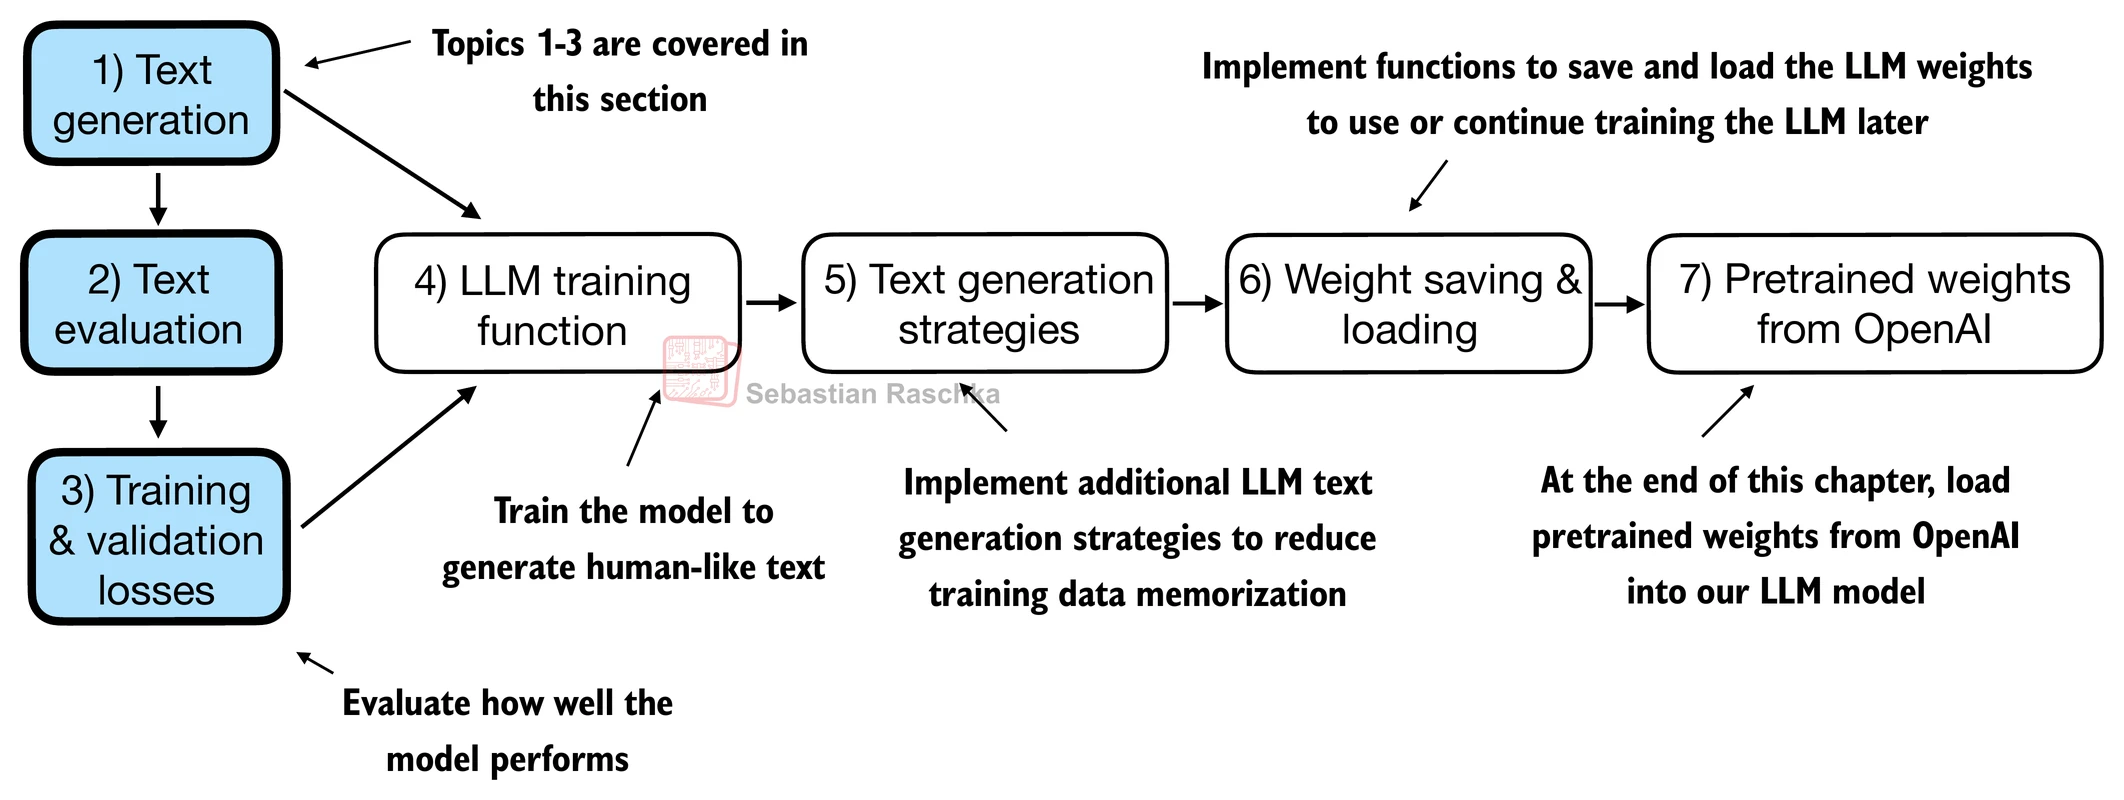

In [33]:
print(f"Targets batch 1:{token_ids_to_text(targets[0], tokenizer)}")
print(f"Output batch 1:"
      f"{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1: effort moves you
Output batch 1: Armed heNetflix


In [34]:
text_idx = 0 
target_probas_1 = probas[text_idx,[0,1,2], targets[text_idx]]
print("Text 1:", target_probas_1.tolist())

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:", target_probas_2.tolist())

Text 1: [7.454051228705794e-05, 3.1060611945576966e-05, 1.1562790859898087e-05]
Text 2: [1.0336668310628738e-05, 5.6775981647660956e-05, 4.7559328777424525e-06]


In [35]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [36]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [37]:
nev_avg_log_probas = avg_log_probas * -1
print(nev_avg_log_probas)

tensor(10.7940)


In [38]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [39]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Flattened logits:" , logits_flat.shape)
print("Flatten targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flatten targets: torch.Size([6])


In [40]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [41]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


Training

In [42]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding = "utf-8") as file:
    text_data = file.read()

In [43]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characcters:", total_characters)
print("Tokens:", total_tokens)


Characcters: 20481
Tokens: 5147


In [44]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [45]:
import torch
from torch.utils.data import  Dataset, DataLoader

class GPTDatabseV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i: i+ max_length]
            target_chunk = token_ids[i+1 : i+ max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
def create_dataloader_v1(txt, batch_size =4, max_length =256, stride =128, shuffle = True,drop_last = True, num_workers = 0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset =GPTDatabseV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return dataloader

In [46]:
'''import sys
sys.path.append("/mnt/data")  # or the folder where you place tokenization.py

from tokenization.py import create_dataloader_v1
'''
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size =2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride  = GPT_CONFIG_124M["context_length"],
    drop_last = True,
    shuffle= True,
    num_workers =0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size =2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = False,
    shuffle = False,
    num_workers = 0
)

In [47]:
print("Trian loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\n Validation loader:")
for x,y in val_loader:
    print(x.shape, y.shape)

Trian loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

 Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [48]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

In [49]:
def calc_loss_loader(data_loader, model, device, num_batches = None):
    total_loss =0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i< num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss/ num_batches

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583690219456
Validation loss: 10.983160018920898


In [60]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [],[], []
    token_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            token_seen += input_batch.numel()
            global_step += 1
             
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(token_seen)
                print(f"Ep {epoch+1} (Step{global_step:06d}):"
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss: .3f}")
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

In [61]:
"""def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches= eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches= eval_iter
        )
        model.train()
        return train_loss, val_loss"""

# filepath: /Users/dhaneshkumarkapadia/Desktop/LargeLanguageModel/pretaining.ipynb
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    was_training = model.training
    model.to(device)
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    if was_training:
        model.train()
    else:
        model.eval()
    return train_loss, val_loss


In [62]:
def generate_and_print_sample(model, tokenizer, device,  start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx= encoded, max_new_tokens = 50,
                                         context_size = context_size)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
        model.train()

In [66]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.0004, weight_decay= 0.1)
num_epochs =10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs = num_epochs, 
    eval_freq=5, eval_iter= 5, start_context="Every effort moves you",
    tokenizer= tokenizer
)


Ep 1 (Step000000):Train loss 9.781,Val loss  9.932
Ep 1 (Step000005):Train loss 8.111,Val loss  8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step000010):Train loss 6.661,Val loss  7.048
Ep 2 (Step000015):Train loss 5.961,Val loss  6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step000020):Train loss 5.726,Val loss  6.629
Ep 3 (Step000025):Train loss 5.201,Val loss  6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step000030):Train loss 4.417,Val loss  6.278
Ep 4 (Step000035):Train loss 4.069,Val loss  6.225
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step000040):Train loss 3.732,Val loss  6.158
Every effort moves you know it was not that the picture--I had the fact by the last I had been--his, 

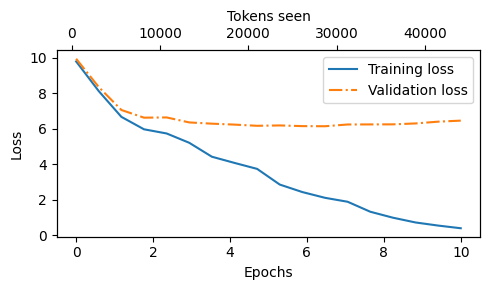

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize = (5,3))
    ax1.plot(epochs_seen, train_losses, label = "Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label = "Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc = "upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha = 0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()

    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [68]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [69]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(model= model,
                                 idx = text_to_token_ids("Every effort moves you", tokenizer),
                                 max_new_tokens = 25,
                                 context_size = GPT_CONFIG_124M["context_length"])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


In [70]:
vocab = {
    "closer": 0,
    "every" : 1,
    "effort":2,
    "forword":3,
    "inches":4,
    "moves":5,
    "pizza":6,
    "toward":7,
    "you":8,

}
inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
next_token_logits = torch.tensor([
    4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79
])
probas = torch.softmax(next_token_logits, dim = 0)
#print(probas)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,
            0.0001,     0.3576,     0.0040])
forword


In [73]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forword


In [74]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
              for i in range(1_000)]
    sample_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sample_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forword
2 x inches
0 x moves
0 x pizza
343 x toward


In [75]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits/ temperature
    return torch.softmax(scaled_logits, dim =0)


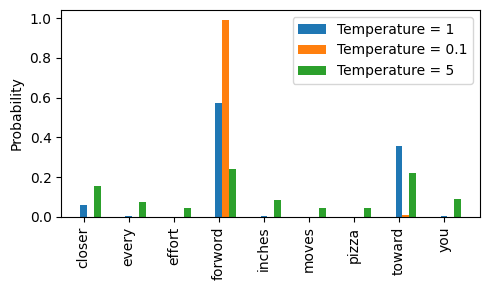

In [76]:
temperatures = [1, 0.1, 5]
scaled_probas = [ softmax_with_temperature(next_token_logits,T)
                 for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize = (5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x+ i * bar_width, scaled_probas[i],
                   bar_width, label =f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation = 90)
ax.legend()
plt.tight_layout()
plt.show()

In [77]:
top_k =3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [78]:
new_logits = torch.where(
    condition = next_token_logits< top_logits[-1],
    input = torch.tensor(float('-inf')),
    other = next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [79]:
topk_probas = torch.softmax(new_logits, dim = 0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [80]:
def generate(model, idx, max_new_tokens, context_size, 
             temperature=0.0, top_k = None, eos_id = None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits /temperature
            probs = torch.softmax(logits, dim =-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else: 
            idx_next = torch.argmax(logits, dim =-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim= 1)
    return idx

In [81]:
torch.manual_seed(123)
token_ids =generate(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens= 15,
    context_size= GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


In [82]:
torch.save(model.state_dict(),"model.pth")


In [83]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location= device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [86]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
},
"model_and_optimizer.pth")

In [87]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr= 5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

In [95]:


import os
import requests


file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"



url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    response = requests.get(url, timeout=60)
    response.raise_for_status()
    with open(file_name, "wb") as f:
        f.write(response.content)
    print(f"Downloaded to {file_name}")



In [98]:
from gpt_download import download_and_load_gpt2
setting, params = download_and_load_gpt2(
    model_size="124M", models_dir= "gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 69.7kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.54MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 99.2kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:00<00:00, 4.15MiB/s] 
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.82MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 787kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 942kiB/s] 


In [101]:
#print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [102]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)


[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [104]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim":768, "n_layers":12, "n_heads":12},
    "gpt2-medium (355M)": {"emb_dim":1024, "n_layers":24, "n_heads":16},
    "gpt2-large (774M)": {"emb_dim":1280, "n_layers":36, "n_heads":20},
    "gpt2-xl (1558M)": {"emb_dim":1600, "n_layers":48, "n_heads":25},
} 

In [105]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [106]:
NEW_CONFIG.update({"context_length":1024})
NEW_CONFIG.update({"qkv_bias":True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                         "Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [117]:
import numpy as np
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"],3,axis =-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
                gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
                gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
                gpt.trf_blocks[b].att.W_value.weight, v_w.T)
            
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"],3,axis =-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
                gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
                gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
                gpt.trf_blocks[b].att.W_value.bias, v_b)
        
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )

        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [118]:
load_weights_into_gpt(gpt,params)
gpt.to(device)

torch.manual_seed(123)
token_ids = generate(
    model = gpt, 
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


